# Dataset & imports


In [ ]:
import pandas as pd
!gdown https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0

df = pd.read_csv('final_dataset.csv', dtype = {'Movie': 'string', 'Reviewer': 'string', 'Review': 'string', 'Score': 'float64', 'Sentiment_scores': 'float64', 'overview': 'string', 'recommend': 'int'}, parse_dates=['Date'])


Downloading...
From (original): https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0
From (redirected): https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0&confirm=t&uuid=f7c7c499-3fe0-47f9-b39b-b1044041812f
To: /content/final_dataset.csv
100% 456M/456M [00:04<00:00, 105MB/s]


In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
import ast

In [ ]:
# extract the necessary columns
# data = df[['Movie','Reviewer','Score','recommend','genres']].copy()
data = df[['Movie','Reviewer','Score','recommend','unique_genres']].copy()

#### Making Genres to a Embedding layer to be passed into the model
Since Genres is in a '['Drama', 'Comedy', 'Romance', 'Foreign']' format, we need to do some additional pre-processing on it

In [ ]:
def changer(x):
  return ast.literal_eval(x)

changer(data['unique_genres'][0])

['Drama', 'Romance', 'Comedy', 'Foreign']

In [ ]:
data['unique_genres'] = data['unique_genres'].apply(lambda x: changer(x))

In [ ]:
# now we find all unqiue genres & max number of genres a movie has (7) & 1048 combinations of genres
unique_genres = []
max_len = 0
for d in data['unique_genres']:
  if len(d) > max_len:
    max_len = len(d)

  for indiv in d:
    if indiv not in unique_genres:
      unique_genres.append(indiv)

print(len(unique_genres))
print(unique_genres)
print(max_len)

20
['Drama', 'Romance', 'Comedy', 'Foreign', 'History', 'War', 'Thriller', 'Mystery', 'Horror', 'Action', 'Crime', 'Adventure', 'Documentary', 'Science Fiction', 'TV Movie', 'Music', 'Animation', 'Family', 'Western', 'Fantasy']
7


In [ ]:
# List of genres
genres = ['Drama', 'Comedy', 'Romance', 'Foreign', 'War', 'History', 'Mystery', 'Thriller', 'Horror', 'Action', 'Adventure', 'Crime', 'Documentary', 'Science Fiction', 'TV Movie', 'Music', 'Animation', 'Family', 'Western', 'Fantasy']

# Create a dictionary mapping each genre to an index
genre_to_index = {genre: index+1 for index, genre in enumerate(genres)}

# Initialize a list of zeros with a length of 20
one_hot_vector = [0] * 21

# Function to create a one-hot vector
def create_one_hot_vector(genre):
    one_hot_vector = [0] * 21
    for ele in genre:
      index = genre_to_index.get(ele)
      if index is not None:
          one_hot_vector[index] = 1
    return torch.tensor(one_hot_vector, dtype=torch.long)

# Example usage
selected_genre = ["Drama", "Comedy", "Romance", "Foreign"]
one_hot_vector = create_one_hot_vector(selected_genre)
print(one_hot_vector)

tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# Alternate means of embedding genres
# # Tokenization
# word_to_index = {word: i for i, word in enumerate(unique_genres)}
# index_to_word = {i: word for word, i in word_to_index.items()}

# # Padding (assuming a maximum sequence length)
# max_seq_length = 10

# # function to make a list of genres to a padded tensor
# def make_tensors(lister):a
#   # Convert words to indices
#   indices = [word_to_index[word] for word in lister]
#     # Padding (assuming a maximum sequence length)
#   max_seq_length = 10
#   padded_indices = indices + [-1] * (max_seq_length - len(indices))  # Pad with -1

#   # Convert to PyTorch tensor
#   padded_tensor = torch.tensor(padded_indices, dtype=torch.long)
#   return padded_tensor

In [ ]:
# make_tensors(["Drama", "Comedy", "Romance", "Foreign"])

In [ ]:
# add the padded_tensor to data
data['padded_genres'] = data['unique_genres']
data['padded_genre'] = data['unique_genres'].apply(lambda x:create_one_hot_vector(x))

In [ ]:
data.head(1)

,Movie,Reviewer,Score,recommend,unique_genres,padded_genres,padded_genre
0,SENSATION,Dennis Schwartz,0.686869,0,"[Drama, Romance, Comedy, Foreign]","[Drama, Romance, Comedy, Foreign]","[tensor(0), tensor(1), tensor(1), tensor(1), t..."


Now Lets add these tensors to our main dataset

# Data pre-processing for NCF

Preprocess the Reviewers and movies into integers (so each movie & Reviewer is given a unique label) from 0 to unique_length so that we can pass it into the embeddings

In [ ]:
n_movies = data.Movie.nunique()
n_users = data.Reviewer.nunique()
print(f"We have {n_movies} unique movies & {n_users} unique users ")

We have 5216 unique movies & 4804 unique users 


Create an extra class to hold on to users, movies & ratings. We use a test size of 15% and random state of 42 standardised for all models

In [ ]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
data.Reviewer = lbl_user.fit_transform(data.Reviewer.values)
data.Movie = lbl_movie.fit_transform(data.Movie.values)

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings, genres):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.genres = genres
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1]
    def __getitem__(self, item):

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]
        genres = self.genres[item]

        # If genres is already a tensor, return it as is
        if isinstance(genres, torch.Tensor):
            genres_tensor = genres
        else:
            genres_tensor = torch.tensor(genres, dtype=torch.long)

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float),
            "genres": genres_tensor
        }

In [ ]:
df_train, df_valid = model_selection.train_test_split(
    data, test_size=0.15, random_state=42, shuffle=True
)

train_dataset = MovieDataset(
    users=df_train.Reviewer.values,
    movies=df_train.Movie.values,
    ratings=df_train.Score.values,
    genres=df_train.padded_genre.values
)

valid_dataset = MovieDataset(
    users=df_valid.Reviewer.values,
    movies=df_valid.Movie.values,
    ratings=df_valid.Score.values,
    genres=df_valid.padded_genre.values
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

    validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2,
                          pin_memory=True)

    print("DataLoader is now using GPU.")
else:
    train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)

    validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)
    print("CUDA is not available. DataLoader remains on CPU.")


DataLoader is now using GPU.


# NCF

We use neural networks to model the intricate relationship & collaborative effect between user & ratings which cannot be captured effectively by matrix factorisation as the interaction is only matrix mulitplication. Hence, we explore the use of neural networks where we use hidden layers to better understand & model this relationship.

It takes in user & movie embeddings (OHV of users & movies represented in a smaller dimension to serve as a lookup table) and learns how to update the embeddings based on the loss


In [ ]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=256,
        # embedding is slightly larger as our num of movies is 5k - have more data but may overfit
        hidden_dim=64,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers - transforms categorical data like userID & movieID from OHV into a continuous denser space
        # we pass in total number of users & the embedding dimension that we want
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        # cos you add both movie & user embeddings before passing through the first layer - capture info b/w the 2
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)

        # final output is simply the predicted rating
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function -> minimise vanishing / exploding gradient problem & dont need to compute so much comapred to softmax
        self.relu = nn.ReLU()

    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings side by side
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        # model tries to learn ratings based on the combined user-movie representation
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

Train the model, MSE Loss is used along with Adam Optimiser

In [ ]:
recommendation_model = RecommendationSystemModel(
    num_users=len(lbl_user.classes_),
    num_movies=len(lbl_movie.classes_)
).to(device)

# set up optimisers & loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3) # fast convergence & decent performance
loss_func = nn.MSELoss()

EPOCHS = 2

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

# set to training mode
recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch

    for train_data in tqdm(train_loader, desc="Training", leave=False):
          # run forward pass
          output = recommendation_model(
              train_data["users"].to(device), train_data["movies"].to(device)
          )

          # Reshape the model output to match the target's shape
          # Removes the singleton dimension torch.size is [32,1] -> [32], why not 64?????
          output = output.squeeze()

          ratings = (train_data["ratings"].to(torch.float32).to(device))

          loss = loss_func(output, ratings)
          total_loss += loss.sum().item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


**Model Evaluation: **

We create a dictionary of <user>: [(predicted rating, true rating)]. Then, we also keep track of total predicted & true ratings.

We will only recommend the movie if it has a rating of more than 0.797980 (identified from EDA as the 75% percentile of ratings given)

In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison = defaultdict(list)

y_test = []
y_pred = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append([pred[0].item(), true.item()])
            y_test.append(RecommendIf(true, threshold))
            y_pred.append(pred)

Function to calculate precision, recall & accuracy given a list of tuple of user ratings(predicted rating, true rating), top k value and the threshold. Note this will give the top k values ONLY for that USER.

Hence, later we will report the average metrics for all users

In [ ]:
from collections import defaultdict

def calculate_precision_recall_accuracy(user_ratings, k, threshold):
    # sorts a list of user_ratings in descending order based on the first element of each tuple in the list
    # -> get top K recommended by users given rating
    # in this case the first element is the predicted rating
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    # # the number of actual relevant item
    # n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    # # the number of predicted relevant item
    # n_est = sum(est >= threshold for est, _ in user_ratings)

    # the number of recommended item that are predicted relevent and within topk
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    # the number of actual relevant item and within topk
    n_rel_k = sum(true_r >= threshold for _, true_r in user_ratings[:k])
    # the number of recommented item that' is also actually relevant & predicted to be relevant in within topk
    n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k])

    # number of items that are in topk but not recommended and predicted to be not recommended for top k
    n_acc = sum( ((est <= threshold) & (act <= threshold)) for est, act in user_ratings[:k])

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel_k if n_rel_k != 0 else 1
    accuracy = (n_acc + n_rel_and_rec_k) / len(user_ratings)
    return precision, recall, accuracy

In [ ]:
user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()

k = 10

for user_id, user_ratings in user_ratings_comparison.items():
    # get precision & recall metrics for each user
    precision, recall,accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users: {average_accuracy:.4f}")

average precision of top 10 movies recommended to them for all users: 0.8232
average recall of top 10 movies recommended to them for all users: 0.7288
average accuracy of top 10 movies recommended to them for all users: 0.6859


Using treshold of 0.79 - 70th percentile instead of 75th (before standardising treshold values amongst other group memebers)

At 2 epochs: 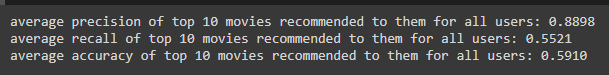

At 5 epochs: 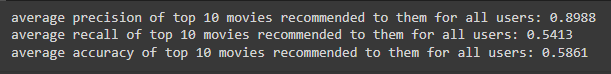

5 epochs with treshold 0.7979
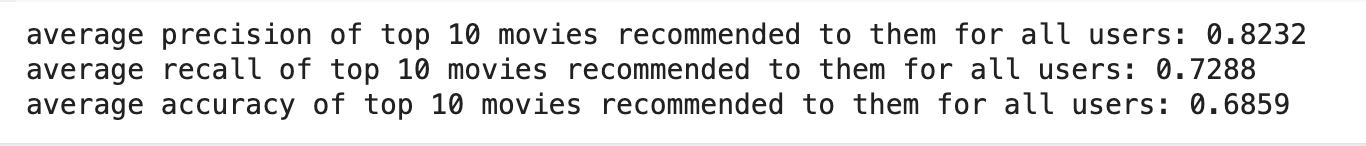

We want to explore the distribution of user precision, recall & accuracy for their top 10 Recommendations. We use a barplot to identify any extra trends

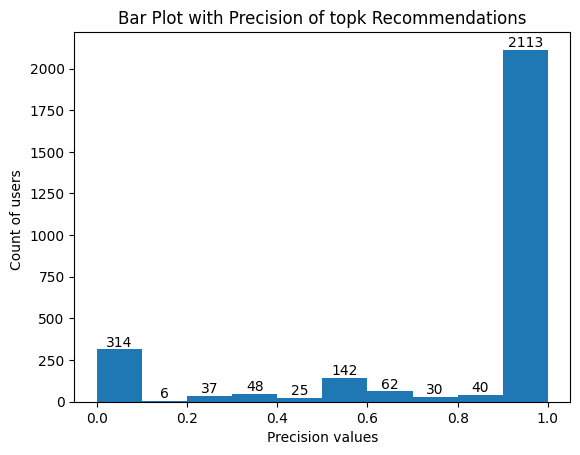

In [ ]:
plt.hist(user_precisions.values())

for rect in plt.gca().patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    plt.text(x_value, y_value, f'{int(y_value)}', ha='center', va='bottom')

plt.xlabel('Precision values')
plt.ylabel('Count of users ')
plt.title('Bar Plot with Precision of topk Recommendations')
plt.show()

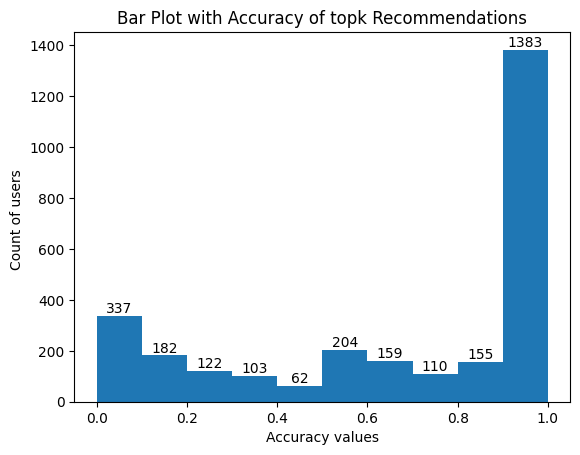

In [ ]:
plt.hist(user_based_accuracy.values())

for rect in plt.gca().patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    plt.text(x_value, y_value, f'{int(y_value)}', ha='center', va='bottom')

plt.xlabel('Accuracy values')
plt.ylabel('Count of users ')
plt.title('Bar Plot with Accuracy of topk Recommendations')
plt.show()

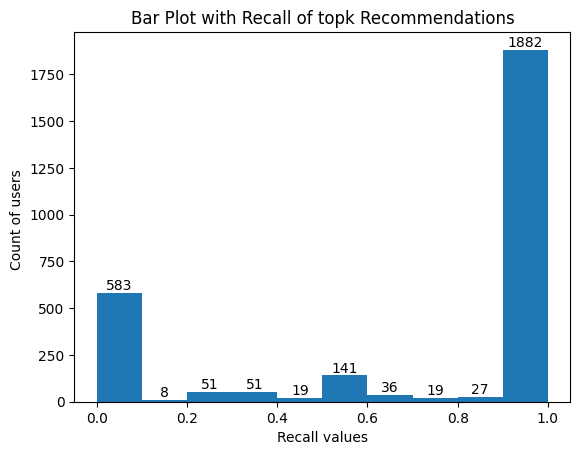

In [ ]:
plt.hist(user_based_recalls.values())

for rect in plt.gca().patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    plt.text(x_value, y_value, f'{int(y_value)}', ha='center', va='bottom')

plt.xlabel('Recall values')
plt.ylabel('Count of users ')
plt.title('Bar Plot with Recall of topk Recommendations')
plt.show()

**Analysis**

There are some users where the model is not able to predict well where the metrics are <= 0.1. Hence, lets explore further in detail




---
Lets check if for those that have poor recall, is the model unable to generalise becuase they have not rated enough movies? Is it the model's shortcoming or a data issue?




In [ ]:
temp_list_recall = []
temp_list_accuracy = []
temp_list_precision = []
for key, value in user_based_recalls.items():
  if value <= 0.1:
    temp_list_recall.append(key)

for key, value in user_based_accuracy.items():
  if value <= 0.1:
    temp_list_accuracy.append(key)

for key, value in user_precisions.items():
  if value <= 0.1:
    temp_list_precision.append(key)

common_elements = set(temp_list_recall).intersection(temp_list_accuracy).intersection(temp_list_precision)

common_elements_list = list(common_elements)
value_counts = data['Reviewer'].value_counts().to_dict()
filtered_dict = {key: value for key, value in value_counts.items() if key in common_elements_list}

first_15_pairs = dict(list(filtered_dict.items()))
print(first_15_pairs)

{3845: 831, 3573: 802, 4558: 791, 222: 787, 3191: 781, 2447: 687, 1888: 512, 3986: 432, 3981: 286, 3480: 55, 1536: 23, 4647: 13, 4706: 7}


Just these 13 people have consistently low accuracy, precision and recall scores (<=0.1). Hence, we hypothesis that likely these users have a very wide range of movie preferences making it difficult to correctly predict for them

# More Complex NCF via HyperParam tuning
Utilising a more complex architecture leads to a better performance than before due to the hidden layers being able to capture more nuances of the collaborative effect of users & movies & ratings

Test 1: Using (32,16,8) as dimensions for hidden layers along with same dropout & number of epochs as above, we get higher precision but lower recall & accuracy, this suggests that our model might be overfitting due to the extra layers

Test 2: Using (32,4) with 2 epochs as dimensions for hidden layers to strike a balance between performance improvement & overfitting, leads to a negligible result

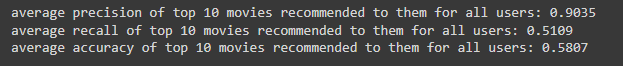

Test 3: Perhaps a more complicated model, needs more training iterations or epoch (2 -> 5) for it to understand the complexities of the interactions and might need more training. From the above, the precision, recall & accuracy has increase significantly and hence, we realise that maybe 2 epochs is not enough to train the model.

This is further supported by the fact that an increase in number of epochs does not improve a slightly less complex model as much as shown in comparison with the results below where using more epochs helped to improve performance.



In [ ]:
class RecommendationSystemModel2(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=32,
        # embedding is slightly larger as our num of movies is 5k - have more data but may overfit
        hidden_dim=(32,16,8),
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel2, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers - transforms categorical data like userID & movieID into a continuous space
        # we pass in total number of users & the embedding dimension
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # creating a more complex hidden layer set up - ONLY CHANGE MADE !!!!!!!!!!!!!!!!
        hidden_layers = []
        input_units = 64
        for num_units in [32,16,8]:
          hidden_layers.append(nn.Linear(input_units, num_units))
          hidden_layers.append(nn.ReLU())
          hidden_layers.append(nn.Dropout(p=dropout_rate))
          input_units = num_units

        hidden_layers.append(nn.Linear(8,1))

        self.MLP = nn.Sequential(*hidden_layers)


    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        output = self.MLP(combined)

        return output

In [ ]:
recommendation_model2 = RecommendationSystemModel2(
    num_users=len(lbl_user.classes_),
    num_movies=len(lbl_movie.classes_)
).to(device)

# set up optimisers & loss function
optimizer = torch.optim.Adam(recommendation_model2.parameters(), lr=1e-3) # fast convergence & decent performance
loss_func = nn.MSELoss()

EPOCHS = 5

import sys
# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    # add to the loss, to find average later
    losses.append(avg_loss)

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

# set to training mode
recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch

    for i, train_data in enumerate(train_loader):
          # run forward pass
          output = recommendation_model2(
              train_data["users"].to(device), train_data["movies"].to(device)
          )

          # Reshape the model output to match the target's shape
          # Removes the singleton dimension torch.size is [32,1] -> [32], why not 64?????
          output = output.squeeze()

          ratings = (train_data["ratings"].to(torch.float32).to(device))

          loss = loss_func(output, ratings)
          total_loss += loss.sum().item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Increment step count by the actual size of the batch
          step_count += len(train_data["users"])

          # Check if it's time to log progress
          if (step_count % log_progress_step == 0 or i == len(train_loader) - 1):  # Log at the end of each epoch
              log_progress(e, step_count, total_loss, log_progress_step, train_dataset_size, losses)
              total_loss = 0

Training on 239590 samples...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 | Step: 239590/239590 | Avg Loss: 0.003480301/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 | Step: 239590/239590 | Avg Loss: 0.003136246

In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison = defaultdict(list)

y_test = []
y_pred = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model2(users, movies)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append([pred[0].item(), true.item()])
            y_test.append(RecommendIf(true, threshold))
            y_pred.append(pred)

user_precisions = dict()
user_based_recalls = dict()

k = 10

for user_id, user_ratings in user_ratings_comparison.items():
    # get precision & recall metrics for each user
    precision, recall,accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users: {average_accuracy:.4f}")

average precision of top 10 movies recommended to them for all users: 0.8861
average recall of top 10 movies recommended to them for all users: 0.5706
average accuracy of top 10 movies recommended to them for all users: 0.5939


Prediction on Training Set

In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison2 = defaultdict(list)

y_test2 = []
y_pred2 = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for train_data in train_loader:
        users = train_data["users"].to(device)
        movies = train_data["movies"].to(device)
        ratings = train_data["ratings"].to(device)
        output = recommendation_model2(users, movies)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison2[user.item()].append([pred[0].item(), true.item()])
            y_test2.append(RecommendIf(true, threshold))
            y_pred2.append(pred)

user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()

k = 10

for user_id, user_ratings in user_ratings_comparison2.items():
    # get precision & recall metrics for each user
    precision, recall,accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users - training: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users - training: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users - training: {average_accuracy:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


average precision of top 10 movies recommended to them for all users - training: 0.8263
average recall of top 10 movies recommended to them for all users - training: 0.7003
average accuracy of top 10 movies recommended to them for all users - training: 0.6019


# CF modified to consider CF & word embeddings of genres

Setting up of Word embeddings of genres

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Set up Model

In [ ]:
class RecommendationSystemModel3(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=32,
        # embedding is slightly larger as our num of movies is 5k - have more data but may overfit
        hidden_dim=(32,16,8),
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel3, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_genres = 21
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers - transforms categorical data like userID & movieID into a continuous space
        # we pass in total number of users & the embedding dimension
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        self.genre_embedding = nn.Embedding(
            num_embeddings=self.num_genres, embedding_dim=21
        )

        # creating a more complex hidden layer set up - ONLY CHANGE MADE !!!!!!!!!!!!!!!!
        hidden_layers = []
        input_units = 64 + 21
        for num_units in [32,16,8]:
          hidden_layers.append(nn.Linear(input_units, num_units))
          hidden_layers.append(nn.ReLU())
          hidden_layers.append(nn.Dropout(p=dropout_rate))
          input_units = num_units

        hidden_layers.append(nn.Linear(8,1))

        self.MLP = nn.Sequential(*hidden_layers)


    def forward(self, users, movies, genres):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)
        genres_embedded = genres

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded, genres_embedded], dim=1)

        output = self.MLP(combined)

        return output

In [ ]:
recommendation_model = RecommendationSystemModel3(
    num_users=len(lbl_user.classes_),
    num_movies=len(lbl_movie.classes_)
).to(device)

# set up optimisers & loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3) # fast convergence & decent performance
loss_func = nn.MSELoss()

EPOCHS = 15

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

# set to training mode
recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch

    for train_data in tqdm(train_loader, desc="Training", leave=False):
          # run forward pass
          output = recommendation_model(
              train_data["users"].to(device), train_data["movies"].to(device), train_data['genres'].to(device)
          )

          # Reshape the model output to match the target's shape
          # Removes the singleton dimension torch.size is [32,1] -> [32], why not 64?????
          output = output.squeeze()

          ratings = (train_data["ratings"].to(torch.float32).to(device))

          loss = loss_func(output, ratings)
          total_loss += loss.sum().item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


Training on 239590 samples...


Training:   0%|          | 0/7488 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|█████████▉| 7485/7488 [00:58<00:00, 134.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison = defaultdict(list)

y_test = []
y_pred = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        genres = valid_data["genres"].to(device)
        output = recommendation_model(users, movies, genres)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append([pred[0].item(), true.item()])
            y_test.append(RecommendIf(true, threshold))
            y_pred.append(pred)

user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()
k = 10

for user_id, user_ratings in user_ratings_comparison.items():
    # get precision & recall metrics for each user
    precision, recall,accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users: {average_accuracy:.4f}")

average precision of top 10 movies recommended to them for all users: 0.7669
average recall of top 10 movies recommended to them for all users: 0.7804
average accuracy of top 10 movies recommended to them for all users: 0.6814


For 10 epochs 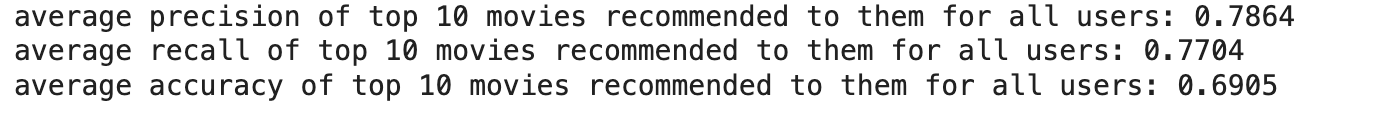

For 15 epoches (it performs worse as there might be overfitting)
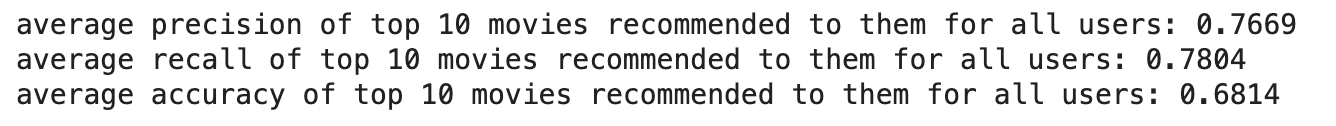

Prediction on Training set

In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison2 = defaultdict(list)

y_test = []
y_pred = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for train_data in train_loader:
        users = train_data["users"].to(device)
        movies = train_data["movies"].to(device)
        ratings = train_data["ratings"].to(device)
        genres = train_data["genres"].to(device)
        output = recommendation_model(users, movies, genres)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison2[user.item()].append([pred[0].item(), true.item()])
            y_test.append(RecommendIf(true, threshold))
            y_pred.append(pred)

user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()
k = 10

for user_id, user_ratings in user_ratings_comparison2.items():
    # get precision & recall metrics for each user
    precision, recall,accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users - training: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users - training: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users - training: {average_accuracy:.4f}")

average precision of top 10 movies recommended to them for all users - training: 0.7847
average recall of top 10 movies recommended to them for all users - training: 0.7720
average accuracy of top 10 movies recommended to them for all users - training: 0.6100


# NewMF

This model uses two subnetworks comprising of generalized matrix factorization (GMF) and MLP(similar to CF) to model the interactions from two pathways instead of simple dot products.

To output of GMF and MLP, instead of simple addition, the second last layers of two subnetworks is concatenated to create a feature vector which can be passed to the further layers, in our case we pass it through a fully connected linear layer to get our final results.

This allows it to leverage on both the advantages of the two methods

From the results, NewMF and CF have almost the same performance metrics suggesting that

https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        # "predictive factors numbers in the model"
        self.factor_num_mf = 32
        self.factor_num_mlp = 32
        # MLP layers. Note that the first layer is the concatenation of user and item embeddings. So 32 is the embedding size."
        self.layers = [64,32,16,8]
        self.dropout = 0.2

        # NCF Embedding
        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        # Matrix Factorisation Embedding
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        # basically ensure that dim on input & output layer matches
        for idx, (in_size, out_size) in enumerate(zip([64,32,16], [32,16,8])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        # at the last layer -> u take the output from the NCF & MF and use it together -> hence dim is as such below
        # you want to get a single output value from 0 to 1
        self.affine_output = nn.Linear(in_features=self.layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    # We initalise the weights so that it is normal to prevent exploding/vanishing graident problem as if weights are 0 centered, easier to train
    # this also allows for faster convergence
    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)

        # for all the fully connected hidden layers, initiliase the weights as uniform (Xavier) distribution
        # helps with effective propogation of weighs during training
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        # make the last layer that is not in the fully connected layer, initliase it as uniform distribution as well
        nn.init.xavier_uniform_(self.affine_output.weight)

        # iterates over all modules (layers) within the neural network model (in ModueList & outside)
        # intiliases bias to 0 if the layer is linear * has a bias (in our case bias=True by default)
        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        # add the user & movie embeddings just like in NCF
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        # matrix factorisation embedding layer
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        # passes in the mlp_vector into the first layer & then sets the output as mlp_vector
        # before passing it to the next layer
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        # add embedding output from both MF & NCF
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        # get 1 single output & make the range to 0 to 1 -> resemble ratings
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        # do .squeeze() to return the rating value ONLY
        return rating.squeeze()

Training the model

In [ ]:
model = NeuMF(len(lbl_user.classes_), len(lbl_movie.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # fast convergence & decent performance
loss_func = nn.MSELoss()

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

EPOCHS = 10

# set to training mode
model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch

    for i, train_data in enumerate(train_loader):

          # run forward pass
          output = model(
              train_data["users"], train_data["movies"]
          )

          # Reshape the model output to match the target's shape
          # Removes the singleton dimension torch.size is [32,1] -> [32], why not 64?????
          output = output.squeeze()

          ratings = (train_data["ratings"].to(torch.float32))

          loss = loss_func(output, ratings)
          total_loss += loss.sum().item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Increment step count by the actual size of the batch
          step_count += len(train_data["users"])


Training on 239590 samples...


In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

embedding_user_mlp.weight 	 torch.Size([4804, 32])
embedding_item_mlp.weight 	 torch.Size([5216, 32])
embedding_user_mf.weight 	 torch.Size([4804, 32])
embedding_item_mf.weight 	 torch.Size([5216, 32])
fc_layers.0.weight 	 torch.Size([32, 64])
fc_layers.0.bias 	 torch.Size([32])
fc_layers.2.weight 	 torch.Size([16, 32])
fc_layers.2.bias 	 torch.Size([16])
fc_layers.4.weight 	 torch.Size([8, 16])
fc_layers.4.bias 	 torch.Size([8])
affine_output.weight 	 torch.Size([1, 40])
affine_output.bias 	 torch.Size([1])


In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison = defaultdict(list)

y_test = []
y_pred = []

threshold = 0.79
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["users"]
        movies = valid_data["movies"]
        ratings = valid_data["ratings"]
        output = model(users, movies)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append([pred.item(), true.item()])
            y_test.append(RecommendIf(true, threshold))
            y_pred.append(pred)

user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()

k = 10

for user_id, user_ratings in user_ratings_comparison.items():
    # get precision & recall metrics for each user
    precision, recall, accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users: {average_accuracy:.4f}")

average precision of top 10 movies recommended to them for all users: 0.8098
average recall of top 10 movies recommended to them for all users: 0.6899
average accuracy of top 10 movies recommended to them for all users: 0.6090


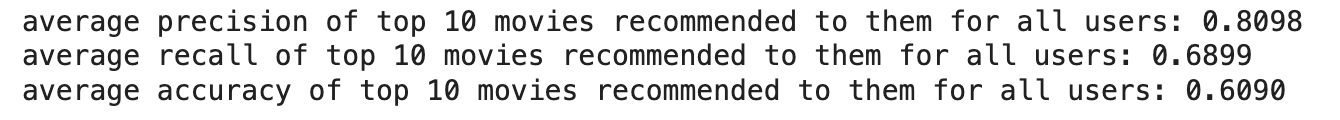

Prediction on Training Set

In [ ]:
# create dictionaries with default values (in this case it will be a list) for keys that haven't been set yet
# so that when we call for it we do not get an error
user_ratings_comparison_train = defaultdict(list)

x_train = []
x_pred = []

threshold = 0.797980
def RecommendIf(val, threshold):
  if val > threshold:
    return 1
  else:
    return 0

with torch.no_grad():
    for train_data in train_loader:
        users = train_data["users"]
        movies = train_data["movies"]
        ratings = train_data["ratings"]
        output = model(users, movies)

        # key is user -> value is list of (predicted rating, true rating)
        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison_train[user.item()].append([pred.item(), true.item()])
            x_train.append(RecommendIf(true, threshold))
            x_pred.append(pred)

user_precisions = dict()
user_based_recalls = dict()
user_based_accuracy = dict()

k = 10

for user_id, user_ratings in user_ratings_comparison_train.items():
    # get precision & recall metrics for each user
    precision, recall, accuracy = calculate_precision_recall_accuracy(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall
    user_based_accuracy[user_id] = accuracy

# get average precision & recall for all users
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)
average_accuracy = sum(rec for rec in user_based_accuracy.values()) / len(user_based_accuracy)

print(f"average precision of top {k} movies recommended to them for all users - training: {average_precision:.4f}")
print(f"average recall of top {k} movies recommended to them for all users - training: {average_recall:.4f}")
print(f"average accuracy of top {k} movies recommended to them for all users - training: {average_accuracy:.4f}")

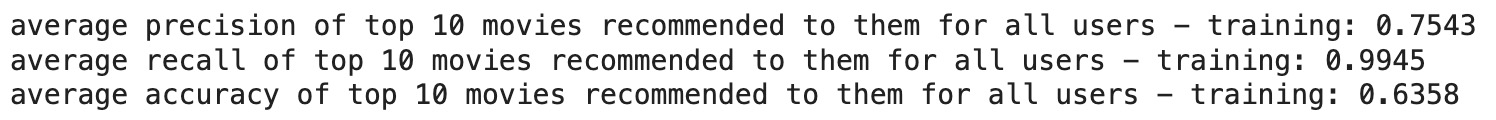

# NGCF - Neural Graph Collaborative Filtering (Exclude due to poor model performance & lack of explainability)

Drawback of the previous methods is that, the collaborative effect(user-item interactions) may not be encoded in the embedding process well. As such, the resultant embeddings may not be sufficient to capture the collaborative f iltering effect.

Hence, we use a bipartite graph structure instead where each user and movie is represented by nodes and interactions between them are represented with  edges

https://github.com/metahexane/ngcf_pytorch_g61/blob/master/ngcf.py

Why the training data needs negative samples? The training data of BPR consists of both positive and negative pairs (missing values). It assumes that the user prefers the positive item over all other non-observed items. -> calculates the bpr loss this way -> (u,i,j) where i is pos sample & j is negative -> want to maximise this prob of i over j

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Here, we split the train & test set. However, we need to ensure that users & movies in the test set are atleast represented once in the training set.

Else, we get an error, becuase it is unable to make a prediction based on that new user/movie since there are no other interactions but also because during the LabelEncoding, we cannot transform indexes that the Encoder has not seen before.

Hence, we are forced to removed some of the users and movies not present in the training set, leading to some loss of data.

In [ ]:
train, test = train_test_split(data, test_size=0.15, random_state=42)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['Reviewer'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['Movie'].values)

train_user_ids = train_df['Reviewer'].unique()
train_item_ids = train_df['Movie'].unique()

test_df = test_df[
  (test_df['Reviewer'].isin(train_user_ids)) & \
  (test_df['Movie'].isin(train_item_ids))
]

test_df['user_id_idx'] = le_user.transform(test_df['Reviewer'].values)
test_df['item_id_idx'] = le_item.transform(test_df['Movie'].values)

n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()

Creating Custom DataLoader

For each user, we get all the movies that he has interacted with & find 1 random movie that he has watched and 1 that he has not watched

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    # for each user -> get a list of movies that he has "interacted" with
    # reset_index() to make it to nice format of column: Reviewer & Movie
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # randomly select users without replacement, takes in list , batch_size
    indices = [x for x in range(n_usr)]

    ## if total number of users is lesser than batch size then randomly select users w replacement
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        # gets 1 random sample until we get 'batch_size' num of users
        users = random.sample(indices, batch_size)

    # sorts it by the Reviewer index
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    # function to return a random value (movieID) that is not in x
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # keep only the Reviewers that are in the current sample -> acts as an filter
    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    # get a random movie ID that the user has interacted with for ALL users in that batch of users_df
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    # get a random movie ID that the user has NOT interacted with for ALL users in that batch of users_df
    # returns it in the form a list of size batch_size
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    # list of (each user,1 item he watched, 1 item he did not watch)
    return (
        torch.LongTensor(list(users)).to(device),
        # we add n_usr to the list of positive & negative movie indexes to ensure that
        # there is confusion between user & movie, eg: this way we wont be confused is it a movie / user if we see index 0 (know that it is a user)
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

**Why use LightGCN over NGCF?**

Unlike NGCF layers, LightGCN combines the intermediate representations of each layer to get the final embeddings by simple addition while for NGCF it uses a non-linear activation function after each layer of embedding before passing it to the next / uses other complex aggregation methods.

LightGCN learns user and item embeddings by propagating them on the user-item interaction graph, and uses the sum of the embeddings learned at all layers as the final embedding.

LightGCN does not use non-linear activation function to reduce complexity because the current user-item embeddings are sufficient.
we draw this conclusion that the two operations inherited from GCN—feature transformation and nonlinear activation—has no contributionon NGCF’seffectiveness. (from LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation)




https://medium.com/@jn2279/better-recommender-systems-with-lightgcn-a0e764af14f9

**What does this LightGCN layer do?**

For each layer, it takes in the embedding of all users & items as rows and cols being the lower dimensional embeddings & all possible edges, uses both to propogate the messages(link between user & movie) and update the embedding values. This is done as each layer considers 1 extra step of influence hence being able to consider slightly higher order relationships

We apply normalisation after every message layer as we dont want the embeddings to have big changes after each layer.

In [ ]:
# single layer
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    # specify the type of aggregation used - sum the messages
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization - to prevent embedding values from getting too big
    from_, to_ = edge_index
    # returns how many nodes is this connected to - aka degree
    deg = degree(to_, x.size(0), dtype=x.dtype)
    # symmetric normalisation - to stabilise training
    deg_inv_sqrt = deg.pow(-0.5)
    # make those that had 0 adjaency value initally to 0
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    # norm - result of symmetric normalization applied to the adjacency matrix
    # scale the feature vectors based on the normalized adjancency matrix
    # to prevent the feature values from growing excessively during convulation

    # x_j is your message gathering from neighbouring nodes
    return norm.view(-1, 1) * x_j

Ensure that LightGCN works well -> nodes that have similar interactions are bound to have similar values

In [ ]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Create the Train edges -> we add u_t & i_t twice to make the edges bi-directional
as its a undirected bipartite graph of user <-> item. Just to initilaise a graph of ALL Possible edges in the training set

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  # from edges index
  torch.cat([u_t, i_t]),
  # to edges index
  torch.cat([i_t, u_t])
)).to(device)

In [ ]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      # number of unqiue Reviewers & items
      num_users,
      num_items,

      # dont need to dropout for this due to the simplicity of the LightGCN
      # as it does not have the extra layers in between
  ):
    super(RecSysGNN, self).__init__()

    # 1st param is num of rows & next is num of cols
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    # holds a list of LightGCN modules where each module has 1 layer
    # allows ur to access & change each layer later during train/eval
    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()

  def init_parameters(self):
      # Authors of LightGCN report higher results with normal initialization
      # cos initial param of model has small random values centered around 0 -> helps w convergence & prevent vanishing / exploding gradients as gradients are not too small/large
      # initialises weights of tensor based on a specific distribution of std = 0.1 (normal)
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    # have a list of all the embedding weights of each layer
    embs = [emb0]

    emb = emb0
    # get embeddings produced at each layer
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    # find the weighted sum to get final embeddings from all the layers - LightGCN
    out = (torch.mean(torch.stack(embs, dim=0), dim=0))

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Get Loss function & Metrics

BPR loss is a pairwise ranking loss function. It optimizes the model parameters based on pairs of movies, where one movies is watched (positive interaction) and the other is not (negative interaction). This is because we want to rank items for each user such that watched movies are ranked higher than the unwatched ones.

Our loss however combines both BPR loss & loss from embeddings to to consider both aspects

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

We get accuracy, recall & precision for topK items

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # compute the score of all user-item pairs in a n_users x n_items matrix
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # create dense tensor of all user-item interactions -> giving interactions as 1 (binary as 1 if interacted)
    i = torch.stack((
        torch.LongTensor(train_df['user_id_idx'].values),
        torch.LongTensor(train_df['item_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(i, v, (n_users, n_items))\
        .to_dense().to(device)

    # mask out training user-item interactions from metric computation
    # by penalizing movies that the user had already watched
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    _, topk_relevance_indices = torch.topk(relevance_score, K)

    # for each user-(top relevant items for k times which will be a list)
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(), columns=['top_indx_' + str(x + 1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # get list of items where the user has watched in the test set AND ones that we identified as to be recommended for each user
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx',
                          right_on=['user_ID'])

    # create an extra column where we keep the values where there is a match
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in
                                    zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # out of k actual recommended items how many did we predict correctly
    metrics_df['recall'] = metrics_df.apply(lambda x: 1 if len(x['item_id_idx']) == 0 else len(x['intrsctn_itm']) / len(x['item_id_idx']), axis=1)
    # out of k of our predicted how many did we end up predicted correctly
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)
    # out all unqiue movies in (what we predicted & actual recommended movies), how many did we predict correctly
    metrics_df['accuracy'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / (len(x['item_id_idx']) + K - len(x['intrsctn_itm'])) , axis=1)
    # metrics_df['accuracy'] = metrics_df.apply(lambda x: 1 if len(set(x['top_rlvnt_itm']) & set(x['item_id_idx'])) == 0 else len(x['intrsctn_itm']) / len(set(x['top_rlvnt_itm']) & set(x['item_id_idx'])) , axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['accuracy'].mean()

## Model Training & Evaluation

In [ ]:
latent_dim = 64
n_layers = 3

EPOCHS = 1
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

Since this model takes very long to run & is very complex, we will attempt to track the loss to identify the optim

In [ ]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  accuracy_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          # get initial embeddings & output emebeddings out
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )

          # penalty for overfitting -> aka each time the model runs
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      # calculate metrics @ each epoch
      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          # used to extract user & item embeddings as they are in rows
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))

          test_topK_recall,  test_topK_precision, test_topK_accuracy = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      # track losses & recall & precision metrics for each epoch
      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      accuracy_list.append(round(test_topK_accuracy,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    accuracy_list
  )

In [ ]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

In [ ]:
light_loss, light_bpr, light_reg, light_recall, light_precision, light_accuracy = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/1 [00:00<?, ?it/s]

Prediction on train set

In [ ]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  accuracy_list = []

  for epoch in tqdm(range(10)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          # get initial embeddings & output emebeddings out
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )

          # penalty for overfitting -> aka each time the model runs
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      # calculate metrics @ each epoch
      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          # used to extract user & item embeddings as they are in rows
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))

          test_topK_recall,  test_topK_precision, test_topK_accuracy = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, train_df, K
          )

      # track losses & recall & precision metrics for each epoch
      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      accuracy_list.append(round(test_topK_accuracy,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list,
    accuracy_list
  )

light_loss, light_bpr, light_reg, light_recall, light_precision, light_accuracy = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/10 [00:00<?, ?it/s]

Get metrics for test set at last epoch

In [ ]:
light_accuracy

[0.0185]

In [ ]:
light_precision

[0.0456]

In [ ]:
light_recall

[0.0833]

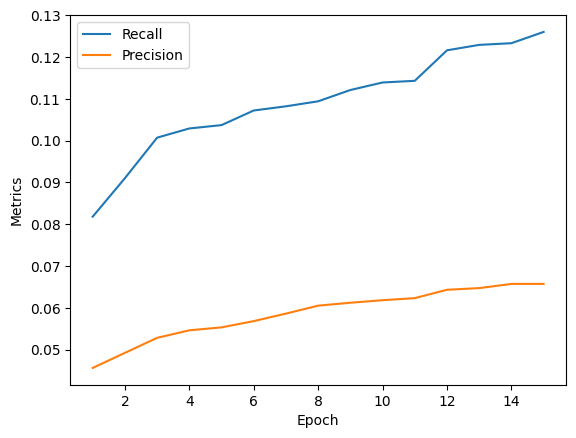

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()